In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sfm_utils # Import our module
import open3d as o3d
import scipy.optimize as optimize
from scipy.optimize import least_squares
from scipy.spatial import cKDTree

%matplotlib inline

def show_images(imgs, titles=None, cmap=None):
    if not isinstance(imgs, (list, tuple)):
        imgs = [imgs]
    n = len(imgs)

    if titles is None:
        titles = [''] * n
    elif isinstance(titles, str):
        titles = [titles]
    if n == 1: #for just one output instance
        plt.figure(figsize=(15, 8))
        img = imgs[0]
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=cmap)
        plt.title(titles[0])
        plt.axis('off')
    else:
        plt.figure(figsize=(10 * n, 10))
        for i in range(n):
            img = imgs[i]
            # converts bgr -> rgb for matpl
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n, i + 1)
            plt.imshow(img, cmap=cmap)
            plt.title(titles[i])
            plt.axis('off')
    plt.show()

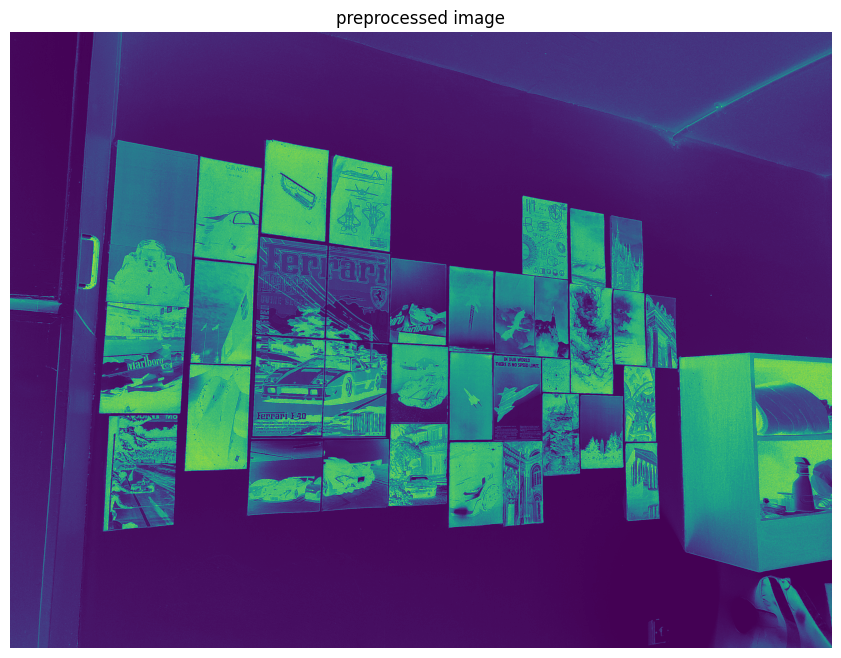

In [50]:
#im reusing this function for enhancing red areas in a picture as the reference picture also contains enough red bits for it to be usable
def just_sharpen(img): #this one overlays the red enhanced value and let the other channels be (not red doesnt mean not black - works well for computing target points)
    blue = img[:, :, 0].astype(np.float64)  
    green = img[:, :, 1].astype(np.float64) 
    red = img[:, :, 2].astype(np.float64)  
    blue = 255 - blue
    green = 255 - green
    red = 255 - red 
    intensity = (red*green*blue) / 3.0
    min_value = intensity.min()
    intensity_shifted = intensity - min_value 
    max_value = intensity_shifted.max()
    intensity_normalized = (intensity_shifted / max_value) * 255.0
    img = cv2.merge([intensity_normalized, intensity_normalized, intensity_normalized])    
    img_float = img.astype(np.float64)
    sharpen_kernel = np.array([
        [ 0, -3,  0],
        [-3,  13, -3],
        [ 0, -3,  0]
    ], dtype=np.float64)
    sharpened = cv2.filter2D(img_float, -1, sharpen_kernel) #conv
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8) #clips in the range 0-255

    # red_enhanced = red * (255 - green) * (255 - blue)    
    # max_value = red_enhanced.max()
    # if max_value == 0:
    #     return img
    # normalized_r = (red_enhanced / max_value * 255).astype(np.uint8)
    # normalized_r_float = normalized_r.astype(np.float32) / 255.0
    
    # binary_r = (normalized_r_float >= 0.5).astype(np.float32)
    # binary_r_uint8 = (binary_r * 255).astype(np.uint8)
    # blue = blue + binary_r_uint8
    # blue_norm = np.clip(blue, 0, 255).astype(np.uint8)
    # green = green + binary_r_uint8
    # green_norm = np.clip(green, 0, 255).astype(np.uint8)
    # img = cv2.merge([blue_norm, green_norm, binary_r_uint8])    
    # img_float = img.astype(np.float64)
    # sharpen_kernel = np.array([
    #     [ 0, -3,  0],
    #     [-3,  13, -3],
    #     [ 0, -3,  0]
    # ], dtype=np.float64)
    # sharpened = cv2.filter2D(img_float, -1, sharpen_kernel) #conv
    # sharpened = np.clip(sharpened, 0, 255).astype(np.uint8) #clips in the range 0-255

    return sharpened

def preprocess_image(img): #tests out the preprocessing that'll be used by the sift matcher
    img = just_sharpen(img)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_eq = cv2.equalizeHist(img) #applies histogram eq        
    img_eq = cv2.GaussianBlur(img, (3, 3), 0) #gaussian w low setting
    
    return img_eq

img = cv2.imread('IMG_1.jpg')
img1 = preprocess_image(img)
show_images(img1 , titles = "preprocessed image") 

In [51]:

# ==============================================================
# Step 1: Feature Matching using SIFT
# ==============================================================

class SIFTMatcher:
    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    def find_matches(self, imgA, imgB, ratio_thresh=1):
        # imgA = just_sharpen(imgA)
        # imgB = just_sharpen(imgB)
        #grayscale conv if needed
        if len(imgA.shape) == 3:
            imgA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
        if len(imgB.shape) == 3:
            imgB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)

        imgA = self._preprocess_image(imgA)
        imgB = self._preprocess_image(imgB)
        #detects keypoints
        kpA, descA = self.sift.detectAndCompute(imgA, None)
        kpB, descB = self.sift.detectAndCompute(imgB, None)
        
        if len(kpA) == 0 or len(kpB) == 0:
            print("No keypoints found in one or both images")
            return np.array([]), np.array([])
            
        #finds 2 best matches for each descriptor
        matches = self.bf.knnMatch(descA, descB, k=2)
        #lowes ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        # print("good matches are :: ", good_matches)
        #extracts all the match point coordinates
        if len(good_matches) > 0:
            ptsA = np.float32([kpA[m.queryIdx].pt for m in good_matches])
            ptsB = np.float32([kpB[m.trainIdx].pt for m in good_matches])
        else:
            print("No good matches found") #returns empty arrays if thats the case
            ptsA = np.array([])
            ptsB = np.array([])
        # print("PtsA are :: " , type(ptsA))
        print(f"Found {len(good_matches)} good matches")
        return ptsA, ptsB

    def _preprocess_image(self, img): #the final version of the preprocessing func is doing exactly nothing as I figured its unnecessary. I can expand on these boiler plates in later deliverables though
        # img_eq = cv2.equalizeHist(img) #applies histogram eq        
        img_eq = cv2.GaussianBlur(img, (3, 3), 0) #gaussian w low setting
        return img_eq

matcher = SIFTMatcher()


In [52]:
def visualize_points(image, points, point_size=3, color=(0, 255, 0)):
    result = image.copy()
    
    for i, (x, y) in enumerate(points):
        cv2.circle(result, (int(x), int(y)), point_size, color, -1) #draws points
        cv2.putText(result, str(i+1), (int(x)+10, int(y)),  #point number label
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    cv2.imwrite("image_with_points.jpg", result)
    print(image.shape)
    return result

Found 56248 good matches
(4000, 3000, 3)


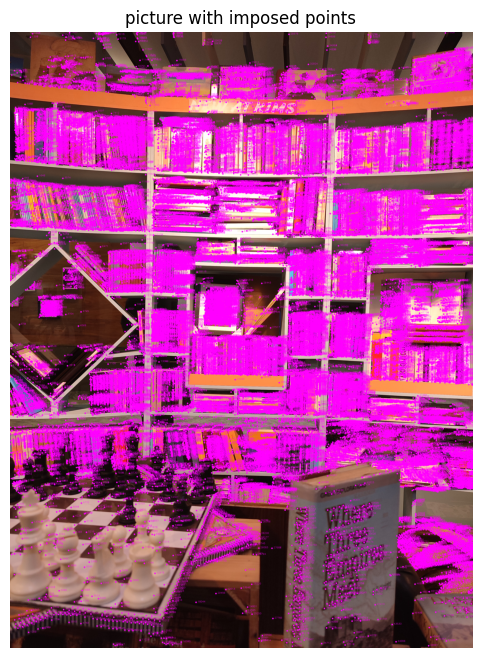

In [53]:
# K = np.array([ #estimated K matrix
#     [2015.30 ,    0., 1500.],
#     [   0., 3582.760, 2000.],
#     [   0.,    0.,    1.]
# ], dtype=np.float64)

K = np.array([ #estimated K matrix
    [2876.19 ,    0., 1500.],
    [   0., 2876.19, 2000.],
    [   0.,    0.,    1.]
], dtype=np.float64)
img1 = cv2.imread('C:/VSCODE/CV/PROJ/dataset/16.jpg')
img2 = cv2.imread('C:/VSCODE/CV/PROJ/dataset/17.jpg')
# img1 = cv2.imread('C:/VSCODE/CV/PROJ/IMG_1.jpg')
# img2 = cv2.imread('C:/VSCODE/CV/PROJ/IMG_2.jpg')

pts1, pts2 = matcher.find_matches(img1, img2)
img_w_points = visualize_points(img1, pts1, point_size = 5, color=(255, 0, 255))
show_images(img_w_points , titles = "picture with imposed points")
# print("points 1 :: " , pts1)
# print("points 2 :: " , pts2)


Essential matrix E estimation: 18299 points are inliers out of 56248 matches
Matrix E:
[[-6.66611717e-03 -3.89498076e-03  8.01072363e-02]
 [ 6.15048308e-02  6.16334699e-03 -6.99794664e-01]
 [-8.23981470e-02  7.02281916e-01 -6.90074967e-04]]


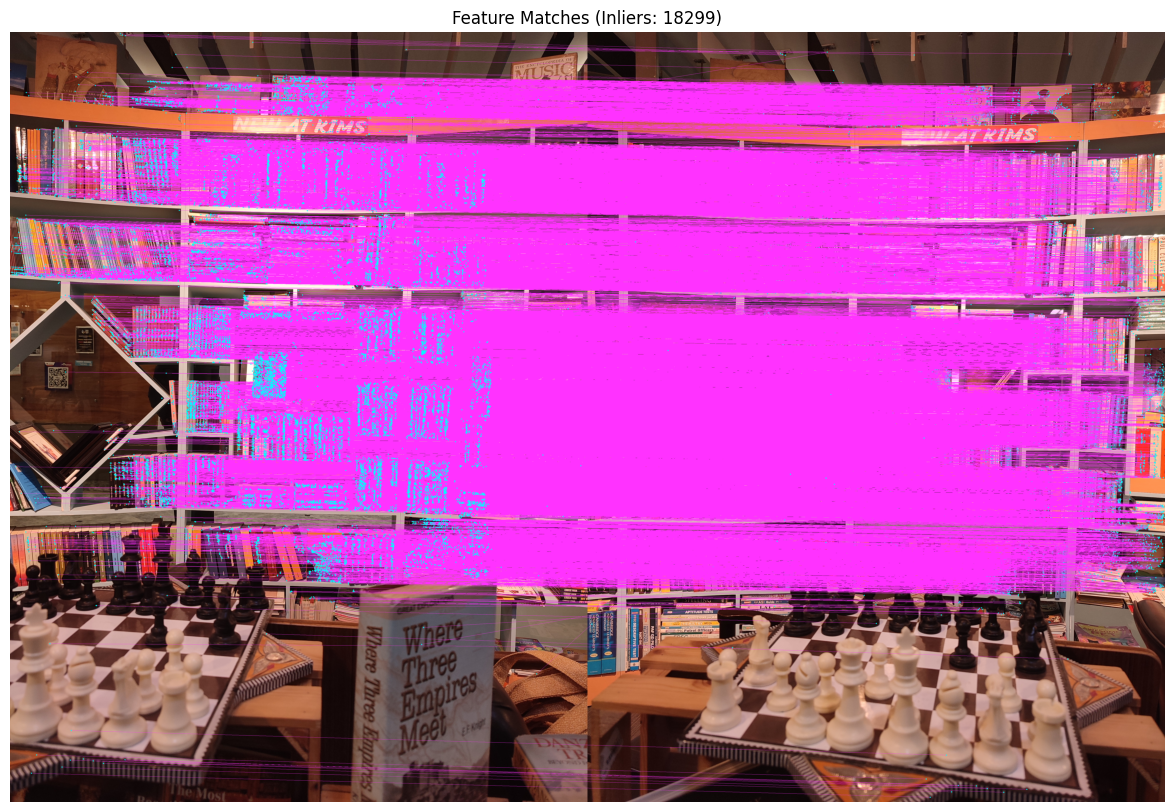

In [54]:
def estimate_essential_matrix(pts1, pts2, K, method=cv2.RANSAC, threshold=0.0005, prob=0.999):  
    #normalises using camera dims using camera instrinsics
    pts1_norm = cv2.undistortPoints(pts1.reshape(-1, 1, 2), K, None) #I dont have the information needed to do the undistortion so just using this to normalise
    pts2_norm = cv2.undistortPoints(pts2.reshape(-1, 1, 2), K, None)
    #estimates essential matric using RANSAC
    E, mask = cv2.findEssentialMat(pts1_norm, pts2_norm, cameraMatrix=np.eye(3), method=method, threshold=threshold, prob=prob)
    #gets inlier points
    mask = mask.ravel().astype(bool)
    inliers_pts1 = pts1[mask.ravel() == True]
    inliers_pts2 = pts2[mask.ravel() == True]
    
    print(f"Essential matrix E estimation: {len(inliers_pts1)} points are inliers out of {len(pts1)} matches")
    print(f"Matrix E:\n{E}")
    
    return E, mask, inliers_pts1, inliers_pts2

def visualize_matches(img1, img2, pts1, pts2):
    #imgs converted to rgb for visualisation
    img1_display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        
    #created composite img
    h1, w1 = img1_display.shape[:2]
    h2, w2 = img2_display.shape[:2]
    composite = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite[:h1, :w1] = img1_display
    composite[:h2, w1:w1+w2] = img2_display
    
    # Draw lines for matches
    for i in range(len(pts1)):
        pt1 = (int(pts1[i][0]), int(pts1[i][1]))
        pt2 = (int(pts2[i][0] + w1), int(pts2[i][1]))
        cv2.line(composite, pt1, pt2, (255, 50, 255), 1)
        cv2.circle(composite, pt1, 3, (0, 255, 255), -1)
        cv2.circle(composite, pt2, 3, (0, 255, 255), -1)
        
    plt.figure(figsize=(20, 10))
    plt.imshow(composite)
    plt.title(f"Feature Matches (Inliers: {len(pts1)})")
    plt.axis('off')
    plt.show()
    image_for_saving = cv2.cvtColor(composite, cv2.COLOR_RGB2BGR)
    cv2.imwrite('inlier_matches.png', image_for_saving)

#tests the essential matrix estimation
E, mask, inliers_pts1, inliers_pts2 = estimate_essential_matrix(pts1, pts2, K)

#visualises the inlier matches
visualize_matches(img1, img2, inliers_pts1, inliers_pts2)

In [ ]:
def recover_pose_from_essential_matrix(E, pts1, pts2, K):
    #pose recovered from essential matrix
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
    print(f"Pose recovery: {np.sum(mask)} points pass cheirality check")
    print(f"Rotation matrix R:\n{R}\n")
    print(f"Translation vector T:\n{t.ravel()}\n")
    
    return R, t, mask

def triangulate_points(pts1, pts2, poses , index):
    #camera proj matrices ->
    #first camera : P1 = K [I | 0] = [K | 0]
    # print("points1 :: " , pts1)
    P1 = poses[index - 1]
    #second camera : P2 = K [R | t]
    P2 = poses[index] 
    #points converted to homogeneous coordinates
    # pts1_hom = cv2.undistortPoints(pts1.reshape(-1, 1, 2), K, None).reshape(-1, 2)
    # pts2_hom = cv2.undistortPoints(pts2.reshape(-1, 1, 2), K, None).reshape(-1, 2)
    
    #points triangulated
    points_3d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    #conv from homogeneous to euclidean coordinates
    points_3d = points_3d_hom / points_3d_hom[3]
    points_3d_euclidean = points_3d[:3].T

    sum = 0
    for point in points_3d_euclidean:
        sum +=  point[2]

    avg_depth = sum / len(points_3d_euclidean) #calculates centroid
    # print("bound z :: " , 2*avg_depth)
    mask = (points_3d_euclidean[:,2] > 0.1) & (points_3d_euclidean[:,2] < 1.5*avg_depth)#bound = 2*centroid
    # colors_filtered = np.array(colors)[valid_depth_mask]
    print(f"triangulated {len(points_3d_euclidean)} 3D points\n")
    return points_3d_euclidean , mask 


def modified_triangulate_points(pts1, pts2, poses , index):

    P1 = poses[index - 1]
    P2 = poses[index] 
    points_3d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3d = points_3d_hom / points_3d_hom[3]
    points_3d_euclidean = points_3d[:3].T

    sum = 0
    for point in points_3d_euclidean:
        sum +=  point[2]

    avg_depth = sum / len(points_3d_euclidean) #calculates centroid
    # print("bound z :: " , 2*avg_depth)
    mask = (points_3d_euclidean[:,2] > 0.1) & (points_3d_euclidean[:,2] < 1.5*avg_depth)#bound = 2*centroid
    # colors_filtered = np.array(colors)[valid_depth_mask]
    print(f"triangulated {len(points_3d_euclidean)} 3D points\n")
    return points_3d_euclidean , mask 

def check_cheirality_condition(points_3d, R, t):    
    #camera poses ->
    #first camera at origin, looks along z-axis
    R1 = np.eye(3)
    t1 = np.zeros(3)

    #second camera
    R2 = R
    t2 = t.ravel()
    
    #checks depth in first camera
    points_cam1 = (R1 @ points_3d.T + t1.reshape(-1, 1)).T
    depth_cam1 = points_cam1[:, 2]
    
    #checks depth in second camera  
    points_cam2 = (R2 @ points_3d.T + t2.reshape(-1, 1)).T
    depth_cam2 = points_cam2[:, 2]
    
    # Points are valid if they have positive depth in both cameras
    valid_mask = (depth_cam1 > 0) & (depth_cam2 > 0)
    
    print(f"Cheirality check: {len(valid_mask)}/{len(points_3d)} points are in front of both cameras")
    
    return valid_mask

def save_point_cloud(points_3d, colors, filename):
    
    # Create PLY header
    header = f"""ply
format ascii 1.0
element vertex {len(points_3d)}
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
"""    
    #writes to PLY file
    with open(filename, 'w') as f:
        f.write(header)
        for i, point in enumerate(points_3d):
            r, g, b = colors[i]
            f.write(f"{point[0]:.6f} {point[1]:.6f} {point[2]:.6f} {int(r)} {int(g)} {int(b)}\n")
    
    print(f"saved {len(points_3d)} points to {filename}")


if len(inliers_pts1) > 0: #triangulates only if enough points available
    R, t, _ = recover_pose_from_essential_matrix(E, inliers_pts1, inliers_pts2, K) #camera pose recovered

    poses = [] #global poses
    rotations = [] #global rotations
    translations = [] #global translations
    P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
    #second camera : P2 = K [R | t]
    P2 = K @ np.hstack([R, t])  
    poses.append(P1)
    poses.append(P2)
    R_1, _ = cv2.Rodrigues(np.eye(3)) #best R
    R_2, _ = cv2.Rodrigues(R)
    rotations.append(R_1)
    rotations.append(R_2)
    translations.append(np.zeros((3, 1)))
    translations.append(t)

    points_3d_euclidean , mask_depth = triangulate_points(inliers_pts1, inliers_pts2, poses , 1) #3d points triangulated
    valid_mask = check_cheirality_condition(points_3d_euclidean, R, t) #cheirality condition
    combined_mask = mask_depth & valid_mask
    points_3d_euclidean = points_3d_euclidean[combined_mask] #points updated with the combined mask 
    #extracts colors from the original images for the point cloud
    #uses the first image to get colors for the points
    colors = []
    for pt in inliers_pts1:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= x < img1.shape[1] and 0 <= y < img1.shape[0]:
            colors.append(img1[y, x][::-1])  #bgr -> rgb
        else:
            colors.append([128, 128, 128])  #defaults to gray
    
    colors = np.array(colors)
    
    #saves point cloud
    save_point_cloud(points_3d_euclidean, colors, "pointcloud.ply")    
    
else:
    print("Error: No inlier points available for triangulation")

Pose recovery: 4656555 points pass cheirality check
Rotation matrix R:
[[ 0.99654235  0.00249956  0.08304872]
 [-0.0032185   0.99995849  0.00852413]
 [-0.08302397 -0.00876194  0.99650903]]

Translation vector T:
[0.99350211 0.11372421 0.00451208]

triangulated 18299 3D points

Cheirality check: 18299/18299 points are in front of both cameras
saved 18257 points to pointcloud.ply


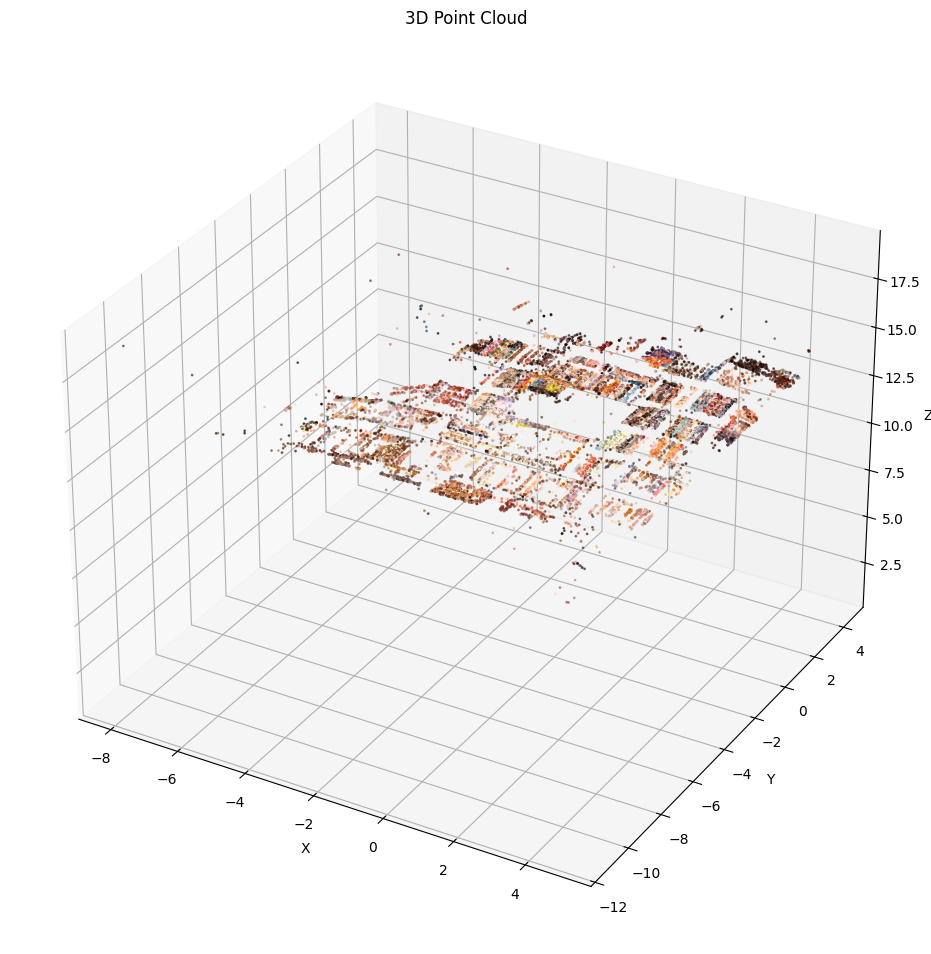

In [56]:
def visualize_point_cloud(points_3d, colors=None, valid_mask=None):

    if valid_mask is not None:
        colors = colors[valid_mask]
    
    fig = plt.figure(figsize=(40, 40))
    
    #normalizes colors for matplotlib (converts from 0-255 to 0-1)
    if colors is not None:
        colors_normalized = colors / 255.0
    else:
        colors_normalized = None
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=colors_normalized, s=1, alpha=0.6)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Point Cloud')


#point cloud visualisation
visualize_point_cloud(points_3d_euclidean, colors, combined_mask)

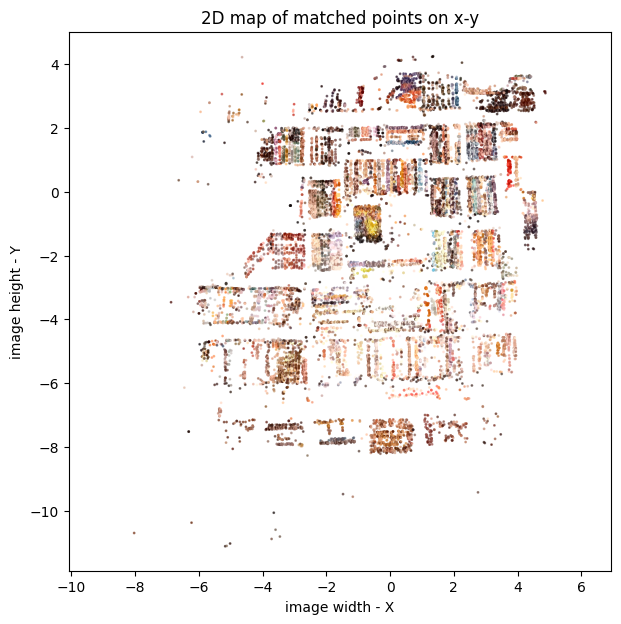

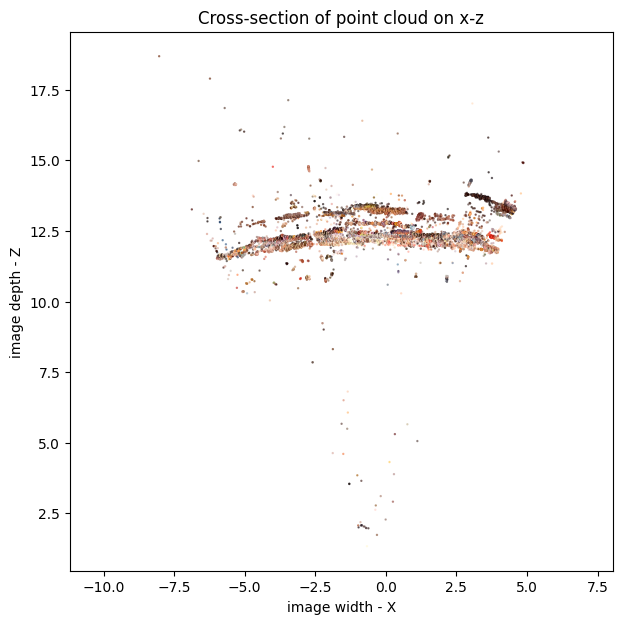

In [57]:
def visualize_2d_map(points_3d_euclidean, colors, combined_mask=None):
    colors = colors[combined_mask]
    colors_normalized = colors / 255.0
    x = points_3d_euclidean[: , 0]
    y = points_3d_euclidean[: , 1]
    z = points_3d_euclidean[: , 2]

    plt.figure(figsize=(7,7))
    plt.scatter(x ,y ,c = colors_normalized, s = 1 ,alpha = 0.6)
    plt.axis('equal')
    plt.title("2D map of matched points on x-y")
    plt.xlabel("image width - X")
    plt.ylabel("image height - Y")

    plt.figure(figsize=(7,7))
    plt.scatter(x ,z ,c = colors_normalized, s = 0.5 ,alpha = 0.6)
    plt.axis('equal')
    plt.title("Cross-section of point cloud on x-z")
    plt.xlabel("image width - X")
    plt.ylabel("image depth - Z")

visualize_2d_map(points_3d_euclidean, colors, combined_mask)



In [58]:
def visualise_pointcloud(path = None):
    pcd = o3d.io.read_point_cloud(path)
    o3d.visualization.draw_geometries([pcd])

In [59]:
# visualise_pointcloud('pointcloud.ply')

In [60]:
# for i in range(1,25):
#     img1 = cv2.imread(f'C:/VSCODE/CV/PROJ/dataset/{i}.jpg')
#     img2 = cv2.imread(f'C:/VSCODE/CV/PROJ/dataset/{i+1}.jpg')

#     pts1, pts2 = matcher.find_matches(img1, img2)
#     E, mask, inliers_pts1, inliers_pts2 = estimate_essential_matrix(pts1, pts2, K)
#     if len(inliers_pts1) > 0: #triangulates only if enough points available
#         R, t, _ = recover_pose_from_essential_matrix(E, inliers_pts1, inliers_pts2, K) #camera pose recovered

#         poses = [] #global poses
#         rotations = [] #global rotations
#         translations = [] #global translations
#         P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
#         #second camera : P2 = K [R | t]
#         P2 = K @ np.hstack([R, t])  
#         poses.append(P1)
#         poses.append(P2)
#         rotations.append(np.eye(3))
#         rotations.append(R)
#         translations.append(np.zeros((3, 1)))
#         translations.append(t)

#         points_3d_euclidean , mask_depth = triangulate_points(inliers_pts1, inliers_pts2, poses , 1) #3d points triangulated
#         valid_mask = check_cheirality_condition(points_3d_euclidean, R, t) #cheirality condition
#         combined_mask = mask_depth & valid_mask
#         points_3d_euclidean = points_3d_euclidean[combined_mask] #points updated with the combined mask 
#         #extracts colors from the original images for the point cloud
#         #uses the first image to get colors for the points
#         colors = []
#         for pt in inliers_pts1:
#             x, y = int(pt[0]), int(pt[1])
#             if 0 <= x < img1.shape[1] and 0 <= y < img1.shape[0]:
#                 colors.append(img1[y, x][::-1])  #bgr -> rgb
#             else:
#                 colors.append([128, 128, 128])  #defaults to gray
        
#         colors = np.array(colors)
        
#         #saves point cloud
#         save_point_cloud(points_3d_euclidean, colors, f"{i}_{i+1}.ply")    
#     else:
#         print("Error: No inlier points available for triangulation")


In [61]:
# visualise_pointcloud('23_24.ply')

In [62]:
point_map = {}
for i in range(0,len(points_3d_euclidean)):
    point_3d = points_3d_euclidean[i]
    point1 = inliers_pts1[i]
    point2 = inliers_pts2[i]
    point_map[i] = {
        '3d_point': point_3d,
        'point1': point1,
        'point2': point2
    }
# print("point map :: " , point_map)

In [63]:
# def iterative_bundle_adjustment(pts_cam2, pts_cam3, cam_idx, pts_cam1, max_iterations = 2000, nudge_step=0.03): 
    
#     R_current = rotations[cam_idx] #init rotation
#     t_current = translations[cam_idx] #init translation
    
#     rvec_current, _ = cv2.Rodrigues(R_current) #converts to rodrigues for easier manipulation (of nudges and allt)
    
#     #trackers
#     best_rvec = rvec_current
#     best_tvec = t_current
#     best_error = float('inf')
    
#     # print(f"Points in cam2: {len(pts_cam2)}, Points in cam3: {len(pts_cam3)}")
#     #gets poses ->
#     P1 = poses[cam_idx - 2]  
#     for iteration in range(max_iterations):
        
#         if iteration == 0:
#             points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
#             masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
#             point_3d_test_masked = points_3d_test[mask]
#             points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
            
#             pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
#             pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
#             error_cam1 = np.mean(np.linalg.norm(masked_cam_1_points - pts_proj1_normalised, axis=1))
#             if error_cam1 < best_error:
#                 best_error = error_cam1
#             fall_back_pose = poses[cam_idx] #case the new proj matrix is worse
            
#         # nudge_step *= 0.999 #nudge step reduced every 10 iteration
#         if (iteration % 2 == 0 and iteration != 0):
#             nudge_step *= 0.999 #nudge step reduced every 10 iteration
#             print("iteration :: " , iteration)
#         # nudges in x,y,z
#         value = 2 * np.random.rand() - 1
#         # value = -1**iteration
#         nudge_x = np.array([[value * nudge_step], [0], [0]])
#         nudge_y = np.array([[0], [value * nudge_step], [0]])
#         nudge_z = np.array([[0], [0], [value * nudge_step]])

#         #block for checking if rotating along X gives us better pose->
        
#         rvec_test_x = best_rvec + nudge_x*0.1

#         R_test_x, _ = cv2.Rodrigues(rvec_test_x) #converts to 3x3 rotation matrix
#         P_test_1_x = K @ np.hstack([R_test_x, best_tvec]) #uses the slightly altered R for the new pose
#         poses[cam_idx] = P_test_1_x
#         points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
#         masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
#         point_3d_test_masked = points_3d_test[mask]
#         points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
        
#         pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
#         pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
#         error_cam1 = np.mean(np.linalg.norm(masked_cam_1_points - pts_proj1_normalised, axis=1))
#         if error_cam1 < best_error:
#             best_error = error_cam1
#             best_rvec = rvec_test_x
#             fall_back_pose = P_test_1_x
#         else:
#             poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
#         print("best error so far after R along X:: " , best_error)
#         print("and the iteration is :: " , iteration)

#         #block for checking if rotating along y gives us better pose->
#         rvec_test_y = best_rvec + nudge_y*0.1

#         R_test_y, _ = cv2.Rodrigues(rvec_test_y) #converts to 3x3 rotation matrix
#         P_test_1_y = K @ np.hstack([R_test_y, best_tvec]) #uses the slightly altered R for the new pose
#         poses[cam_idx] = P_test_1_y
#         points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
#         masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
#         point_3d_test_masked = points_3d_test[mask]
#         points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
        
#         pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
#         pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
#         error_cam1 = np.mean(np.linalg.norm(masked_cam_1_points - pts_proj1_normalised, axis=1))
#         if error_cam1 < best_error:
#             best_error = error_cam1
#             best_rvec = rvec_test_y
#             fall_back_pose = P_test_1_y
#         else:
#             poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
#         print("best error so far after R along Y:: " , best_error)
#         print("and the iteration is :: " , iteration)

#         #same2same but for the z rotation->
#         rvec_test_z = best_rvec + nudge_z*0.1
#         R_test_z, _ = cv2.Rodrigues(rvec_test_z) #converts to 3x3 rotation matrix
#         P_test_1_z = K @ np.hstack([R_test_z, best_tvec]) #uses the slightly altered R for the new pose
#         poses[cam_idx] = P_test_1_z
#         points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
#         masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
#         point_3d_test_masked = points_3d_test[mask]
#         points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
        
#         pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
#         pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
#         error_cam1 = np.mean(np.linalg.norm(masked_cam_1_points - pts_proj1_normalised, axis=1))
#         if error_cam1 < best_error:
#             best_error = error_cam1
#             best_rvec = rvec_test_z
#             fall_back_pose = P_test_1_z
#         else:
#             poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
#         print("best error so far after R along Z:: " , best_error)
#         print("and the iteration is :: " , iteration)

#         R_best, _ = cv2.Rodrigues(best_rvec) #best R

#         #block for determining best translation->
#         #well check x first
#         tvec_test_x = best_tvec + nudge_x
#         P_test_2_x = K @ np.hstack([R_best, tvec_test_x]) #uses the slightly altered T for the new pose
#         poses[cam_idx] = P_test_2_x
        
#         points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
#         masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
#         point_3d_test_masked = points_3d_test[mask]
#         points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
        
#         pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
#         pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
#         error_cam1 = np.mean(np.linalg.norm(masked_cam_1_points - pts_proj1_normalised, axis=1))
#         if error_cam1 < best_error:


#             best_error = error_cam1
#             best_tvec = tvec_test_x
#             fall_back_pose = P_test_2_x
#         else:
#             poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
#         print("best error so far after T along X :: " , best_error)
#         print("and the iteration is :: " , iteration)

#         #checks y translation->
#         tvec_test_y = best_tvec + nudge_y
#         P_test_2_y = K @ np.hstack([R_best, tvec_test_y]) #uses the slightly altered T for the new pose
#         poses[cam_idx] = P_test_2_y
        
#         points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
#         masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
#         point_3d_test_masked = points_3d_test[mask]
#         points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
        
#         pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
#         pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
#         error_cam1 = np.mean(np.linalg.norm(masked_cam_1_points - pts_proj1_normalised, axis=1))
#         if error_cam1 < best_error:
#             best_error = error_cam1
#             best_tvec = tvec_test_y
#             fall_back_pose = P_test_2_y
#         else:
#             poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
#         print("best error so far after T along Y :: " , best_error)
#         print("and the iteration is :: " , iteration)

#         #checks y translation->
#         tvec_test_z = best_tvec + nudge_z
#         P_test_2_z = K @ np.hstack([R_best, tvec_test_z]) #uses the slightly altered T for the new pose
#         poses[cam_idx] = P_test_2_z
        
#         points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
#         masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
#         point_3d_test_masked = points_3d_test[mask]
#         points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
        
#         pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
#         pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
#         error_cam1 = np.mean(np.linalg.norm(masked_cam_1_points - pts_proj1_normalised, axis=1))
#         if error_cam1 < best_error:
#             best_error = error_cam1
#             best_tvec = tvec_test_z
#             fall_back_pose = P_test_2_z
#         else:
#             poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
#         print("best error so far after T along Z :: " , best_error)
#         print("and the iteration is :: " , iteration)

                
#     # Apply best pose found to global lists
#     R_best, _ = cv2.Rodrigues(best_rvec) #converts back to rotation matrix

#     rotations[cam_idx] = R_best
#     translations[cam_idx] = best_tvec
        


In [64]:
def iterative_bundle_adjustment(pts_cam2, pts_cam3, cam_idx, pts_cam1, points_3d , max_iterations = 150, nudge_step=0.3): 
    
    R_current = rotations[cam_idx] #init rotation
    t_current = translations[cam_idx] #init translation
    
    rvec_current, _ = cv2.Rodrigues(R_current) #converts to rodrigues for easier manipulation (of nudges and allt)
    
    #trackers
    best_rvec = rvec_current
    best_tvec = t_current
    best_error = 1e6
    
    rotation_error_reduction = 0
    translation_error_reduction = 0
    last_edit_index = 0
    # print(f"Points in cam2: {len(pts_cam2)}, Points in cam3: {len(pts_cam3)}")
    #gets poses ->
    for iteration in range(max_iterations):
        
        if iteration == 0:
            points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
            # masked_cam_1_points = pts_cam1[mask] #gives us all the triangulated points that cam1 EXPECTS TO SEE
            point_3d_test_masked = points_3d_test[mask]
            points_3d_masked = points_3d[mask]
            # points_3d_hom = np.hstack([point_3d_test_masked, np.ones((len(point_3d_test_masked), 1))]).T #converts points to homogeneous
            
            # pts_proj1 = P1 @ points_3d_hom #cam one proj matrix used to get points in cam1 in new point cloud AS OBSERVED
            # pts_proj1_normalised = (pts_proj1[:2] / pts_proj1[2]).T #normalised
            error_cam1 = np.mean(np.linalg.norm(point_3d_test_masked - points_3d_masked, axis=1))
            if error_cam1 < best_error:
                best_error = error_cam1
            fall_back_pose = poses[cam_idx] #case the new proj matrix is worse
            
        nudge_step *= 0.995 #nudge step every iteration
        # if (iteration % 200 == 0 and iteration != 0): #nudge step reduced every 10 iteration
        #     nudge_step *= 0.7 #nudge step reduced every 10 iteration
            # print("iteration :: " , iteration)
        # nudges in x,y,z
        # value = 2 * np.random.rand() - 1
        value = -1**iteration
        nudge_x = np.array([[value * nudge_step], [0], [0]])
        nudge_y = np.array([[0], [value * nudge_step], [0]])
        nudge_z = np.array([[0], [0], [value * nudge_step]])

        #block for checking if rotating along X gives us better pose->
        
        rvec_test_x = best_rvec + nudge_x*0.1

        R_test_x, _ = cv2.Rodrigues(rvec_test_x) #converts to 3x3 rotation matrix
        P_test_1_x = K @ np.hstack([R_test_x, best_tvec]) #uses the slightly altered R for the new pose
        poses[cam_idx] = P_test_1_x
        points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
        point_3d_test_masked = points_3d_test[mask]
        points_3d_masked = points_3d[mask]
        error_cam1 = np.mean(np.linalg.norm(point_3d_test_masked - points_3d_masked, axis=1))
        if error_cam1 < best_error:
            rotation_error_reduction += (best_error - error_cam1)
            best_error = error_cam1
            best_rvec = rvec_test_x
            fall_back_pose = P_test_1_x
            print("the rotation applied :: " , nudge_x*0.1)
            last_edit_index = iteration
        else:
            poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
        print("best error so far after R along X:: " , best_error)
        # print("and the iteration is :: " , iteration)

        #block for checking if rotating along y gives us better pose->
        rvec_test_y = best_rvec + nudge_y*0.1

        R_test_y, _ = cv2.Rodrigues(rvec_test_y) #converts to 3x3 rotation matrix
        P_test_1_y = K @ np.hstack([R_test_y, best_tvec]) #uses the slightly altered R for the new pose
        poses[cam_idx] = P_test_1_y
        points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
        point_3d_test_masked = points_3d_test[mask]
        points_3d_masked = points_3d[mask]
        error_cam1 = np.mean(np.linalg.norm(point_3d_test_masked - points_3d_masked, axis=1))
        if error_cam1 < best_error:
            rotation_error_reduction += (best_error - error_cam1)
            best_error = error_cam1
            best_rvec = rvec_test_y
            fall_back_pose = P_test_1_y
            print("the rotation applied :: " , nudge_y*0.1)
            last_edit_index = iteration
        else:
            poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
        print("best error so far after R along Y:: " , best_error)
        # print("and the iteration is :: " , iteration)

        #same2same but for the z rotation->
        rvec_test_z = best_rvec + nudge_z*0.1

        R_test_z, _ = cv2.Rodrigues(rvec_test_z) #converts to 3x3 rotation matrix
        P_test_1_z = K @ np.hstack([R_test_z, best_tvec]) #uses the slightly altered R for the new pose
        poses[cam_idx] = P_test_1_z
        points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
        point_3d_test_masked = points_3d_test[mask]
        points_3d_masked = points_3d[mask]
        error_cam1 = np.mean(np.linalg.norm(point_3d_test_masked - points_3d_masked, axis=1))
        if error_cam1 < best_error:
            rotation_error_reduction += (best_error - error_cam1)
            best_error = error_cam1
            best_rvec = rvec_test_z
            fall_back_pose = P_test_1_z
            print("the rotation applied :: " , nudge_z*0.1)
            last_edit_index = iteration
        else:
            poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
        print("best error so far after R along Z:: " , best_error)
        # print("and the iteration is :: " , iteration)

        R_best, _ = cv2.Rodrigues(best_rvec) #best R

        #block for determining best translation->
        #well check x first
        tvec_test_x = best_tvec + nudge_x
        P_test_2_x = K @ np.hstack([R_best, tvec_test_x]) #uses the slightly altered T for the new pose
        poses[cam_idx] = P_test_2_x
        
        points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
        point_3d_test_masked = points_3d_test[mask]
        points_3d_masked = points_3d[mask]
        error_cam1 = np.mean(np.linalg.norm(point_3d_test_masked - points_3d_masked, axis=1))
        if error_cam1 < best_error:
            translation_error_reduction += (best_error - error_cam1)
            best_error = error_cam1
            best_tvec = tvec_test_x
            fall_back_pose = P_test_2_x
            print("the translation applied :: " , nudge_x)
            last_edit_index = iteration

        else:
            poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
        print("best error so far after T along X :: " , best_error)
        # print("and the iteration is :: " , iteration)

        #checks y translation->
        tvec_test_y = best_tvec + nudge_y
        P_test_2_y = K @ np.hstack([R_best, tvec_test_y]) #uses the slightly altered T for the new pose
        poses[cam_idx] = P_test_2_y
        
        points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
        point_3d_test_masked = points_3d_test[mask]
        points_3d_masked = points_3d[mask]
        error_cam1 = np.mean(np.linalg.norm(point_3d_test_masked - points_3d_masked, axis=1))
        if error_cam1 < best_error:
            translation_error_reduction += (best_error - error_cam1)
            best_error = error_cam1
            best_tvec = tvec_test_y
            fall_back_pose = P_test_2_y
            print("the translation applied :: " , nudge_y)
            last_edit_index = iteration

        else:
            poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
        print("best error so far after T along Y :: " , best_error)
        # print("and the iteration is :: " , iteration)

        #checks y translation->
        tvec_test_z = best_tvec + nudge_z
        P_test_2_z = K @ np.hstack([R_best, tvec_test_z]) #uses the slightly altered T for the new pose
        poses[cam_idx] = P_test_2_z
        
        points_3d_test, mask = triangulate_points(pts_cam2, pts_cam3, poses, cam_idx) #triangulation gets us 3d points we can use for calculation reproj errors
        point_3d_test_masked = points_3d_test[mask]
        points_3d_masked = points_3d[mask]
        error_cam1 = np.mean(np.linalg.norm(point_3d_test_masked - points_3d_masked, axis=1))
        if error_cam1 < best_error:
            translation_error_reduction += (best_error - error_cam1)
            best_error = error_cam1
            best_tvec = tvec_test_z
            fall_back_pose = P_test_2_z
            print("the translation applied :: " , nudge_z)
            last_edit_index = iteration
        else:
            poses[cam_idx] = fall_back_pose #reverts to old pose if error worsens
        print("best error so far after T along Z :: " , best_error)
        print("and the iteration is :: " , iteration)

                
    # Apply best pose found to global lists
    R_best, _ = cv2.Rodrigues(best_rvec) #converts back to rotation matrix
    print("reduction in rotation error :: " , rotation_error_reduction)
    print("reduction in translation error :: " , translation_error_reduction)
    print("last edit made at iteration :: " , last_edit_index)
    rotations[cam_idx] = R_best
    translations[cam_idx] = best_tvec
        


In [65]:
# print(poses[0])

In [66]:
global_point_cloud = []
global_colors = []
for color in colors:
    global_colors.append(color)
for point in points_3d_euclidean:
    global_point_cloud.append(point)

In [ ]:
dataset = 'C:/VSCODE/CV/PROJ/dataset/'
def add_pose(img_index):    
    last_image_path = f"{dataset}{img_index}.jpg"
    new_image_path = f"{dataset}{img_index+1}.jpg"

    img1 = cv2.imread(last_image_path)
    img2 = cv2.imread(new_image_path)
    pts1 , pts2 = matcher.find_matches(img1, img2)
    # print("length of pts1 :: " , len(pts1))
    # print("length of pts2 :: " , len(pts2))
    pts1_norm = cv2.undistortPoints(pts1.reshape(-1, 1, 2), K, None) #I dont have the information needed to do the undistortion so just using this to normalise
    pts2_norm = cv2.undistortPoints(pts2.reshape(-1, 1, 2), K, None)
    #estimates essential matric using RANSAC
    E , mask = cv2.findEssentialMat(pts1_norm, pts2_norm, cameraMatrix=np.eye(3), method=cv2.RANSAC, threshold=0.0005, prob=0.999) #I dont really need the essential matrix just using it to apply ransac before moving onto the next step // ended up using this for initial guesses 
    #gets inlier points
    mask = mask.ravel().astype(bool)
    inliers_pts1 = pts1[mask.ravel() == True]
    inliers_pts2 = pts2[mask.ravel() == True]
    R1, t1, _ = recover_pose_from_essential_matrix(E, inliers_pts1, inliers_pts2, K) #get the initial rotations and translation guesses
    rvec_init, _ = cv2.Rodrigues(R1)

    ref_coords = []
    for idx , data in point_map.items():
        ref_coords.append(data['point2']) #extracts the 2d point of the second image from global map and stores as a list
    ref_coords = np.array(ref_coords)
    print("ref coords are :: " , ref_coords)
    tree = cKDTree(ref_coords)
    dist_threshold = 0.001 #null threshold // either there are matches in the second frame of the three with the 3d point cloud and the third frame or there arent
    distances, indices = tree.query(inliers_pts1, k=1, distance_upper_bound=dist_threshold) #finds closest neighbour to inlierpts1 in ref coordinates 
    print(indices)
    points_2d_pnp = [] #the point matches in frame 3
    points_3d_pnp = [] #the 3d matched points from the prev cloud
    first_cam_2d_list = [] # Points observed in first camera (for bundle adjustment later)
    mask_for_bundle_adjustment = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):        
        if dist < dist_threshold:
            mask_for_bundle_adjustment.append(True)
            found_pid = idx #id noted for the point in the set threshold
            # print(found_pid)
            # print(idx)
            first_cam_2d = point_map[found_pid]['point1'] #point observed in the first cam of the 3
            p3d = point_map[found_pid]['3d_point'] #3d point seen in the new pose     
            p2d = inliers_pts2[i] #distances are iterated in order of inliner_pts1 so this holds well
            points_3d_pnp.append(p3d)
            points_2d_pnp.append(p2d)
            first_cam_2d_list.append(first_cam_2d)
        else:
            mask_for_bundle_adjustment.append(False)
    inliers_pts1_masked = inliers_pts1[mask_for_bundle_adjustment]
    inliers_pts2_masked = inliers_pts2[mask_for_bundle_adjustment]
    print(f"Matched {len(points_3d_pnp)} points within {dist_threshold}px threshold.")
    points_3d_pnp = np.array(points_3d_pnp, dtype=np.float32)
    points_2d_pnp = np.array(points_2d_pnp, dtype=np.float32)

    _ , rvec, tvec, _ = cv2.solvePnPRansac(
        points_3d_pnp,
        points_2d_pnp,
        K,
        None,  # No distortion
        rvec=rvec_init,
        tvec=t1,
        useExtrinsicGuess=True,
        iterationsCount=10000,
        reprojectionError=6,
        confidence=0.99,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    r_mat, _ = cv2.Rodrigues(rvec)
    print("rvec is :: " , rvec)
    # R_world = r_mat.T
    # t_world = -np.dot(R_world, tvec)
    rotations.append(rvec)
    translations.append(tvec)
    P = K @ np.hstack([r_mat, tvec])
    poses.append(P)
    
    first_cam_2d_arr = np.array(first_cam_2d_list) #converts the first cam observations to array for manipulation

    iterative_bundle_adjustment( #uses points observed by all three points for pose refinement
        inliers_pts1_masked,  #cam2 observed points
        inliers_pts2_masked,  #cam3 observed points
        (len(poses) - 1),  #index of newly added camera
        first_cam_2d_arr,  #cam1 observed points 
        points_3d_pnp
    )
    
    # Re-triangulate with refined pose
    points_3d , mask_depth = triangulate_points(inliers_pts1, inliers_pts2, poses, img_index - 15)

    combined_mask1 = mask_depth 
    points_3d = points_3d[combined_mask1] #points updated with the combined mask 
    #extracts colors from the original images for the point cloud
    #uses the first image to get colors for the points
    colors1 = []
    for pt in inliers_pts2:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= x < img2.shape[1] and 0 <= y < img2.shape[0]:
            colors1.append(img2[y, x][::-1])  #bgr -> rgb
        else:
            colors1.append([128, 128, 128])  #defaults to gray
    colors1 = np.array(colors1, dtype=np.float32)

    visualize_point_cloud(points_3d, colors1, combined_mask1)  #visualizes point cloud
    
    #updates global points
    colors_of_mapped_points1 = colors1[combined_mask1]
    for col in colors_of_mapped_points1:
        global_colors.append(col)
    for pt in points_3d:
        global_point_cloud.append(pt)

    point_map1 = {} #i overwrite over previous correspondances such that the next image would only be comparing to 
    for i in range(0,len(points_3d)):
        point_3d = points_3d[i]
        point1 = inliers_pts1[i]
        point2 = inliers_pts2[i]
        point_map1[i] = {
            '3d_point': point_3d,
            'point1': point1,
            'point2': point2
        }
    save_point_cloud(points_3d, colors1, "pointcloud.ply")    

    return points_3d ,point_map1 , combined_mask1 , colors1 

Found 58204 good matches
Pose recovery: 4738665 points pass cheirality check
Rotation matrix R:
[[ 0.9930844  -0.00149746  0.11739304]
 [ 0.00329058  0.99988084 -0.01508219]
 [-0.11735647  0.01536418  0.992971  ]]

Translation vector T:
[ 0.98847147 -0.01885635 -0.15022843]

ref coords are ::  [[ 538.85034 1233.0757 ]
 [ 538.85034 1233.0757 ]
 [ 509.08994 1331.9248 ]
 ...
 [2987.51    2012.1382 ]
 [2987.4868  2017.6819 ]
 [2985.564   1898.1663 ]]
[18257 18257 18257 ... 17689 18257 18257]
Matched 8169 points within 0.001px threshold.
triangulated 8169 3D points

triangulated 8169 3D points

best error so far after R along X::  2.9832387
triangulated 8169 3D points

best error so far after R along Y::  2.9832387
triangulated 8169 3D points

best error so far after R along Z::  2.9832387
triangulated 8169 3D points

best error so far after T along X ::  2.9832387
triangulated 8169 3D points

best error so far after T along Y ::  2.9832387
triangulated 8169 3D points

best error so far aft

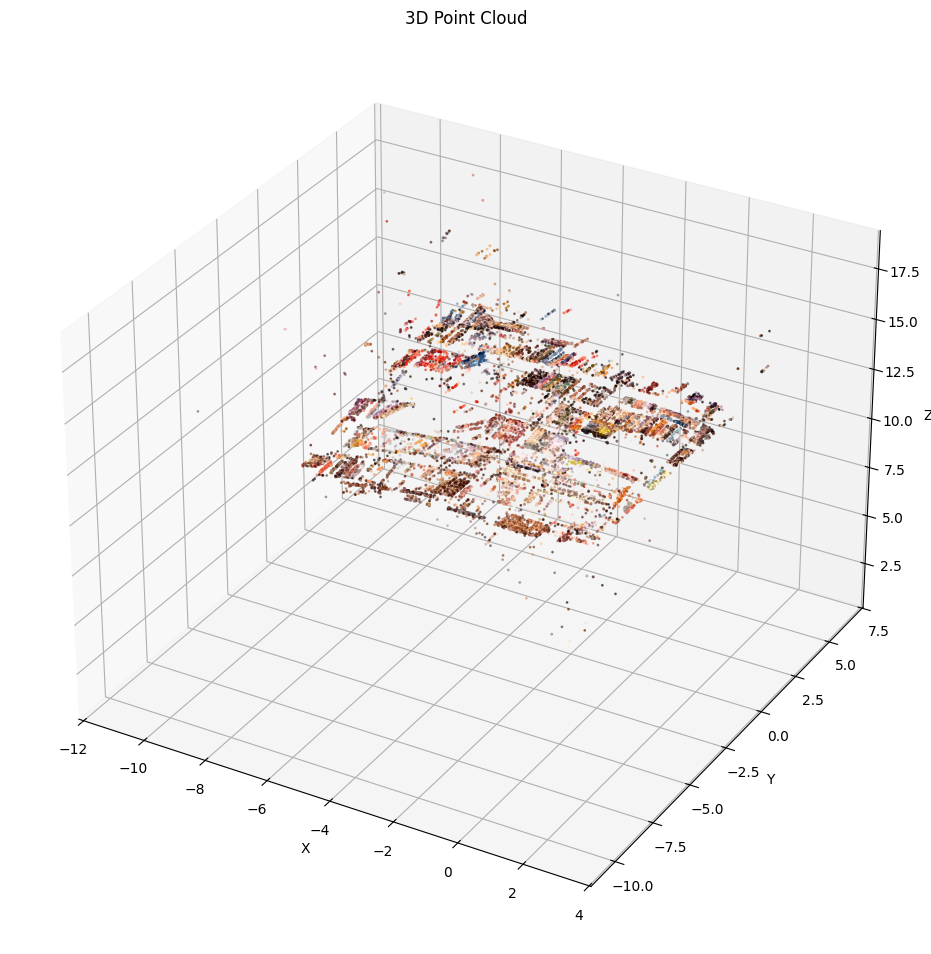

In [68]:
points_3d_euclidean, point_map, combined_mask, colors = add_pose(17)
# points_3d_euclidean, point_map, combined_mask, colors = add_pose(18)
# points_3d_euclidean, point_map, combined_mask, colors = add_pose(19)
# points_3d_euclidean, point_map, combined_mask, colors = add_pose(20)
# points_3d_euclidean, point_map, combined_mask, colors = add_pose(21)

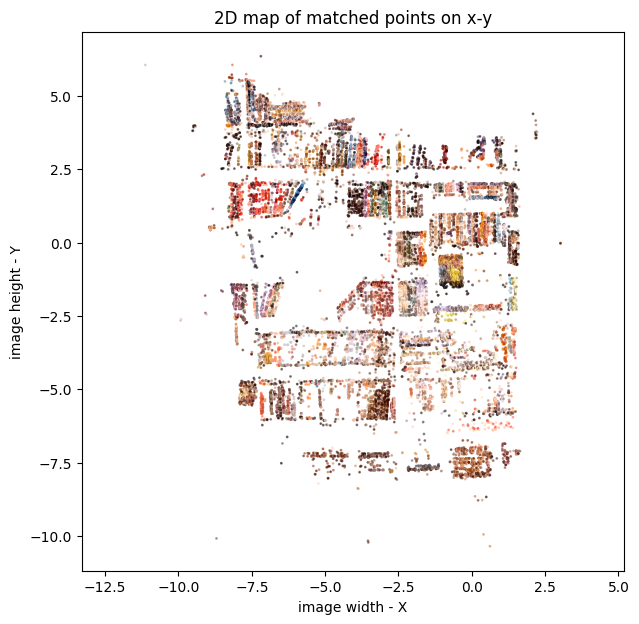

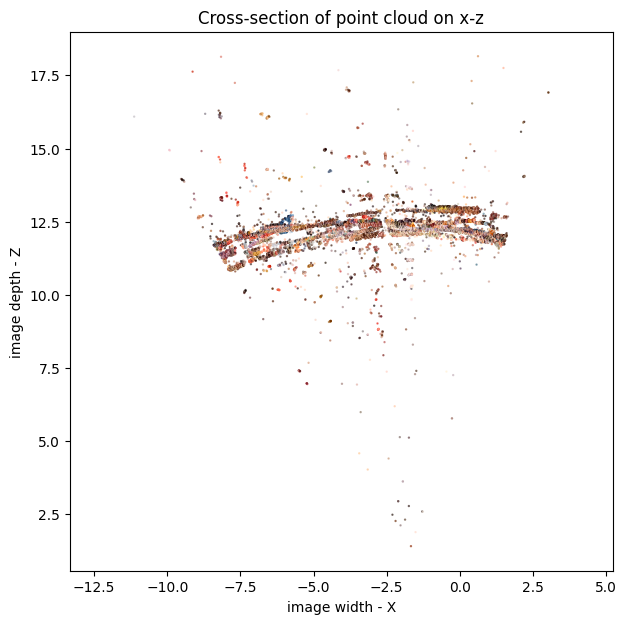

In [69]:
visualize_2d_map(points_3d_euclidean, colors, combined_mask)

In [70]:
visualise_pointcloud('pointcloud.ply')

In [71]:
save_point_cloud(global_point_cloud, global_colors, "global_pointcloud.ply")    

saved 36723 points to global_pointcloud.ply


In [72]:
visualise_pointcloud('global_pointcloud.ply')